# Decision Tree

The purpose of this notebook is to compare the use of grid search, random search, and Bayesian hyperparameter optimization to find optimal hyperparameter settings for a decision tree.

The hyperparameters being evaluated are:

* maximum depth
* maximum number of features to consider at each split
* minimum number of samples per leaf
* minimum number of samples required to split

# Imports

In [1]:
import os
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import skopt
from skopt import BayesSearchCV
from skopt.utils import point_asdict
from skopt.space.space import Integer, Real, Categorical
from skopt.callbacks import DeltaYStopper, TimerCallback

from data_utils import get_CIFAR10_data  # use code adapted from CS 682 to get the CIFAR10 data

# Load data

In [2]:
# Load the (preprocessed) CIFAR10 data

# Note the data from get_CIFAR10_data are in shape (N, C, W, H). Then we reshape the data to have one row per image. 
# To visualize a given image (x_train[i], for example), run the following:
#     plt.imshow(x_train[i].reshape(3, 32, 32).transpose(1, 2, 0).astype('uint8'))

data = get_CIFAR10_data(subtract_mean=True)
for k, v in data.items():
    tmp = v.shape
    if len(tmp) > 1:
        data[k] = v.reshape((v.shape[0], -1))
    print('{}: {} --> {}'.format(k, tmp, data[k].shape))

x_train = data['X_train']
y_train = data['y_train']
x_test = data['X_test']
y_test = data['y_test']

X_train: (50000, 3, 32, 32) --> (50000, 3072)
y_train: (50000,) --> (50000,)
X_test: (1000, 3, 32, 32) --> (1000, 3072)
y_test: (1000,) --> (1000,)


In [3]:
# define the splitting strategy, which will be used for all approaches
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=682)

In [4]:
# Subset the data to 4 classes for runtime purposes, and because the simpler models
# don't tend to get good accuracy when there are many classes
np.random.seed(175)
classes = np.random.choice(range(10), size=4, replace=False)
print(classes)

x_train_4class = x_train[np.isin(y_train, classes)]
y_train_4class = y_train[np.isin(y_train, classes)]

# check on size of dataset
print([x_train_4class.shape, y_train_4class.shape])

# check on class balance
np.unique(y_train_4class, return_counts=True)

[7 2 8 0]
[(20000, 3072), (20000,)]


(array([0, 2, 7, 8]), array([5000, 5000, 5000, 5000]))

# Grid Search

In [5]:
gs_hyperparameters = {
    'max_depth': [25, 50, 100, 500, 2000], 
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': range(2, 45, 7),  # 7
    'min_samples_leaf': range(1, 100, 15),  # 7
}

In [6]:
clf = DecisionTreeClassifier(random_state=682)

gs = GridSearchCV(clf,
                  param_grid=gs_hyperparameters,
                  scoring='accuracy',
                  cv=cv_folds,
                  refit=False,
                  verbose=2, 
                  n_jobs=1)

print('Beginning grid search at {}...'.format(datetime.now().strftime('%H:%M:%S')))
gs.fit(x_train_4class, y_train_4class)

gs_results = []
for i in range(len(gs.cv_results_['params'])):
    result = {'params' : gs.cv_results_['params'][i], 
              'mean_metric' : gs.cv_results_['mean_test_score'][i], 
              'mean_fit_time': gs.cv_results_['mean_fit_time'][i],
              'mean_score_time': gs.cv_results_['mean_score_time'][i]}
    gs_results += [result]
    print('accuracy = {} ({} seconds): {} '.format(round(result['mean_metric'], 4),
                                                   round(result['mean_fit_time'], 2),
                                                   result['params']), flush=True)


print('\nBest model:')
print(max(gs_results, key=lambda item: item['mean_metric']))

with open('decisiontree_gs_results_{}.pkl'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), 'wb') as f:
    pickle.dump({'gs_results': gs_results, 'gs': gs}, f)
    
print('Finished grid search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))

Beginning grid search at 20:46:10...
Fitting 5 folds for each of 490 candidates, totalling 2450 fits
[CV] max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   1.0s
[CV] max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   1.0s
[CV] max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   1.0s
[CV] max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   1.0s
[CV] max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, total=   1.0s
[CV] max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=9 
[CV]  max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=9, total=   1.0s
[CV] max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=9 
[CV]  max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=9, total=   1.0s
[CV] max_depth=25, max_features=sqrt, min

[Parallel(n_jobs=1)]: Done 2450 out of 2450 | elapsed: 22.6min finished


accuracy = 0.5187 (0.33 seconds): {'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 61, 'min_samples_split': 2} 
accuracy = 0.5187 (0.33 seconds): {'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 61, 'min_samples_split': 9} 
accuracy = 0.5187 (0.32 seconds): {'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 61, 'min_samples_split': 16} 
accuracy = 0.5187 (0.33 seconds): {'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 61, 'min_samples_split': 23} 
accuracy = 0.5187 (0.33 seconds): {'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 61, 'min_samples_split': 30} 
accuracy = 0.5187 (0.33 seconds): {'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 61, 'min_samples_split': 37} 
accuracy = 0.5187 (0.33 seconds): {'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 61, 'min_samples_split': 44} 
accuracy = 0.5142 (0.33 seconds): {'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 76, 'min_samples

## Grid Search Plots

In [7]:
print('\nBest model:')
print(max(gs_results, key=lambda item: item['mean_metric']))


Best model:
{'params': {'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 46, 'min_samples_split': 2}, 'mean_metric': 0.5333, 'mean_fit_time': 0.6648169994354248, 'mean_score_time': 0.028083038330078126}


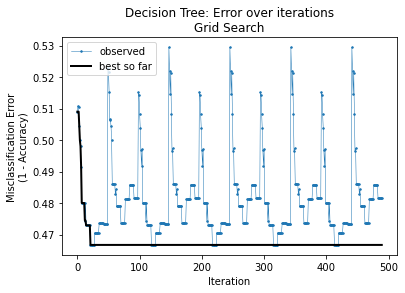

In [35]:
# convergence plot
accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Decision Tree: Error over iterations\nGrid Search")
plt.legend()

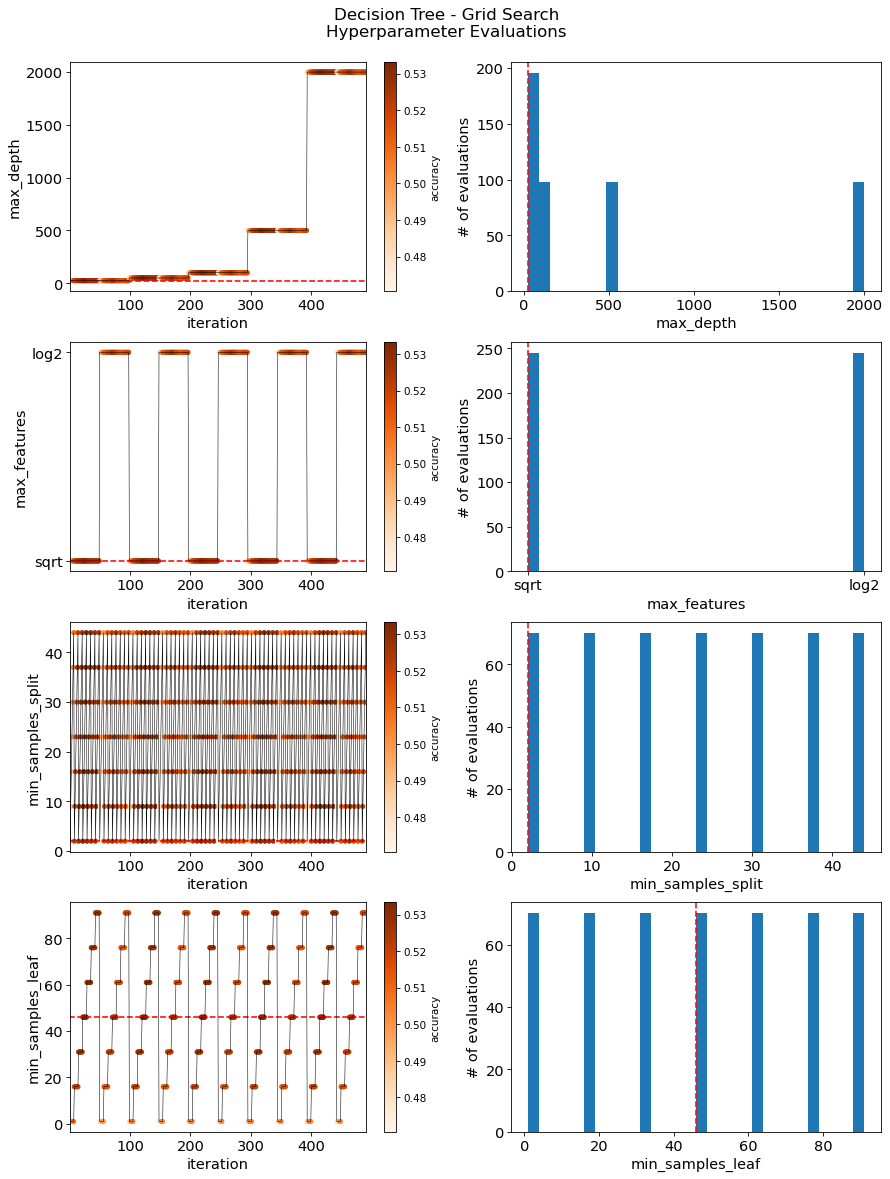

In [9]:
accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

params = gs_hyperparameters.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = [x['params'][param] for x in gs_results]
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = gs.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("Decision Tree - Grid Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.98])

# Random Search

In [10]:
rs_hyperparameters = {
    'max_depth': range(25, 2001),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': range(2, 45),
    'min_samples_leaf': range(1, 100)
}

N_EVALS = 490  # same number as were evaluated in grid search above

In [11]:
clf = DecisionTreeClassifier(random_state=682)

rs = RandomizedSearchCV(clf,
                        param_distributions=rs_hyperparameters,
                        n_iter=N_EVALS,
                        scoring='accuracy',
                        cv=cv_folds,
                        refit=False,
                        verbose=5, 
                        n_jobs=1,
                        random_state=682)


print('\n--------------------------------------\nBeginning random search at {}...'.format(datetime.now().strftime('%H:%M:%S')))
rs.fit(x_train_4class, y_train_4class)

rs_results = []
for i in range(len(rs.cv_results_['params'])):
    result = {'params' : rs.cv_results_['params'][i], 
              'mean_metric' : rs.cv_results_['mean_test_score'][i], 
              'mean_fit_time': rs.cv_results_['mean_fit_time'][i],
              'mean_score_time': rs.cv_results_['mean_score_time'][i]}
    rs_results += [result]
    print('accuracy = {} ({} seconds): {} '.format(round(result['mean_metric'], 4),
                                                   round(result['mean_fit_time'], 2),
                                                   result['params']), flush=True)


print('\nBest model:')
print(max(rs_results, key=lambda item: item['mean_metric']))

with open('decisiontree_rs_results_{}.pkl'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), 'wb') as f:
    pickle.dump({'rs_results': rs_results, 'rs': rs}, f)
    
print('Finished with random search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))


--------------------------------------
Beginning random search at 21:08:48...
Fitting 5 folds for each of 490 candidates, totalling 2450 fits
[CV] min_samples_split=16, min_samples_leaf=10, max_features=sqrt, max_depth=387 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_split=16, min_samples_leaf=10, max_features=sqrt, max_depth=387, score=0.498, total=   0.9s
[CV] min_samples_split=16, min_samples_leaf=10, max_features=sqrt, max_depth=387 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  min_samples_split=16, min_samples_leaf=10, max_features=sqrt, max_depth=387, score=0.531, total=   0.9s
[CV] min_samples_split=16, min_samples_leaf=10, max_features=sqrt, max_depth=387 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  min_samples_split=16, min_samples_leaf=10, max_features=sqrt, max_depth=387, score=0.508, total=   0.8s
[CV] min_samples_split=16, min_samples_leaf=10, max_features=sqrt, max_depth=387 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s


[CV]  min_samples_split=16, min_samples_leaf=10, max_features=sqrt, max_depth=387, score=0.493, total=   0.8s
[CV] min_samples_split=16, min_samples_leaf=10, max_features=sqrt, max_depth=387 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.4s remaining:    0.0s


[CV]  min_samples_split=16, min_samples_leaf=10, max_features=sqrt, max_depth=387, score=0.517, total=   0.9s
[CV] min_samples_split=20, min_samples_leaf=39, max_features=sqrt, max_depth=1992 
[CV]  min_samples_split=20, min_samples_leaf=39, max_features=sqrt, max_depth=1992, score=0.517, total=   0.7s
[CV] min_samples_split=20, min_samples_leaf=39, max_features=sqrt, max_depth=1992 
[CV]  min_samples_split=20, min_samples_leaf=39, max_features=sqrt, max_depth=1992, score=0.538, total=   0.7s
[CV] min_samples_split=20, min_samples_leaf=39, max_features=sqrt, max_depth=1992 
[CV]  min_samples_split=20, min_samples_leaf=39, max_features=sqrt, max_depth=1992, score=0.537, total=   0.7s
[CV] min_samples_split=20, min_samples_leaf=39, max_features=sqrt, max_depth=1992 
[CV]  min_samples_split=20, min_samples_leaf=39, max_features=sqrt, max_depth=1992, score=0.531, total=   0.7s
[CV] min_samples_split=20, min_samples_leaf=39, max_features=sqrt, max_depth=1992 
[CV]  min_samples_split=20, min

[Parallel(n_jobs=1)]: Done 2450 out of 2450 | elapsed: 22.7min finished


accuracy = 0.5264 (0.73 seconds): {'min_samples_split': 40, 'min_samples_leaf': 27, 'max_features': 'sqrt', 'max_depth': 197} 
accuracy = 0.5208 (0.33 seconds): {'min_samples_split': 26, 'min_samples_leaf': 67, 'max_features': 'log2', 'max_depth': 1426} 
accuracy = 0.5266 (0.76 seconds): {'min_samples_split': 43, 'min_samples_leaf': 21, 'max_features': 'sqrt', 'max_depth': 60} 
accuracy = 0.5304 (0.68 seconds): {'min_samples_split': 23, 'min_samples_leaf': 45, 'max_features': 'sqrt', 'max_depth': 508} 
accuracy = 0.5204 (0.62 seconds): {'min_samples_split': 7, 'min_samples_leaf': 86, 'max_features': 'sqrt', 'max_depth': 341} 
accuracy = 0.5081 (0.37 seconds): {'min_samples_split': 22, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 1408} 
accuracy = 0.5251 (0.62 seconds): {'min_samples_split': 36, 'min_samples_leaf': 79, 'max_features': 'sqrt', 'max_depth': 796} 
accuracy = 0.527 (0.34 seconds): {'min_samples_split': 5, 'min_samples_leaf': 44, 'max_features': 'log2', 'max_

## Random Search Plots

In [12]:
print('\nBest model:')
print(max(rs_results, key=lambda item: item['mean_metric']))


Best model:
{'params': {'min_samples_split': 8, 'min_samples_leaf': 54, 'max_features': 'sqrt', 'max_depth': 1347}, 'mean_metric': 0.5337, 'mean_fit_time': 0.6562073230743408, 'mean_score_time': 0.027849340438842775}


In [13]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

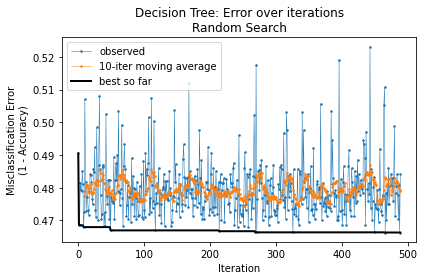

In [36]:
# convergence plot, RS
accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Decision Tree: Error over iterations\nRandom Search")
plt.legend()
plt.tight_layout()

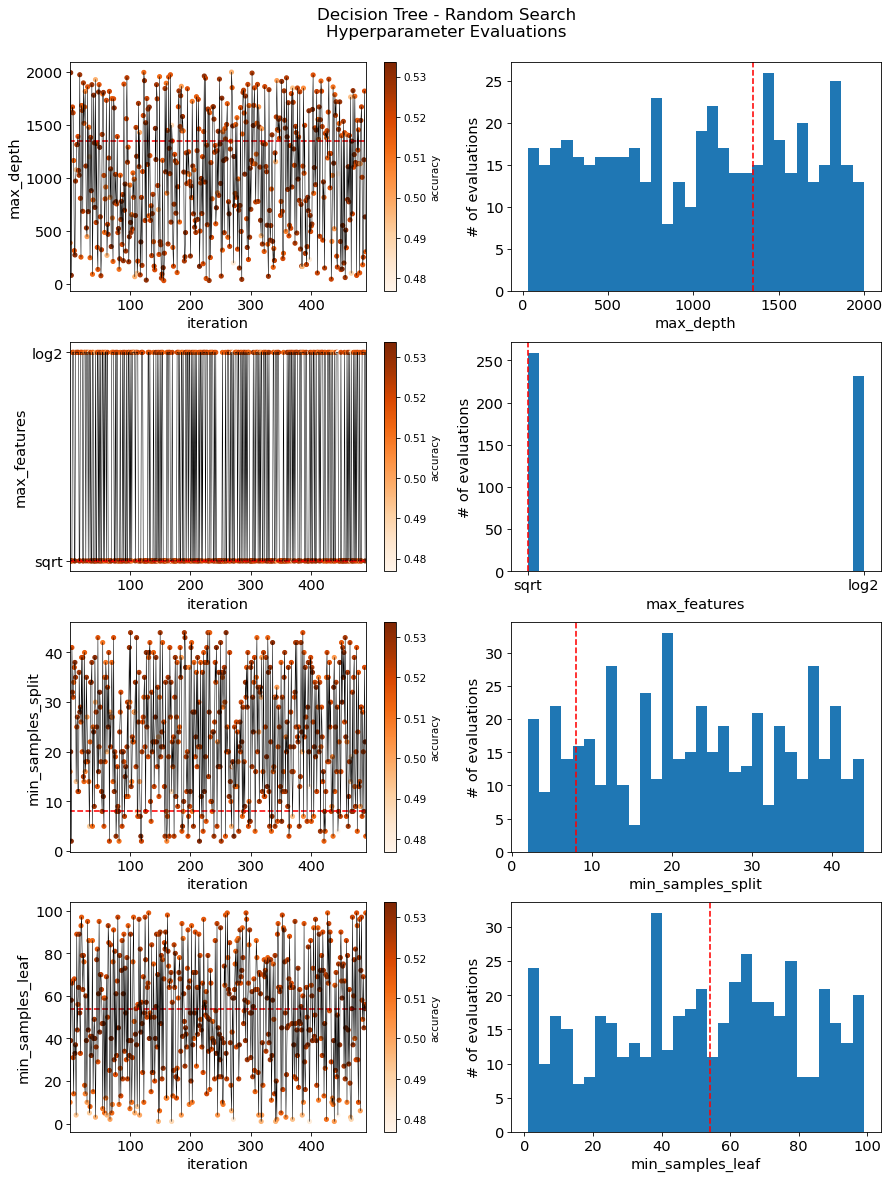

In [15]:
accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs


params = rs_hyperparameters.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = [x['params'][param] for x in rs_results]
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = rs.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("Decision Tree - Random Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.98])

# Bayesian Search

In [5]:
bs_hyperparameters = {
    'max_depth': Integer(25, 2000),  # bounds are *inclusive*
    'max_features': Categorical(['sqrt', 'log2']),
    'min_samples_split': Integer(2, 45),
    'min_samples_leaf': Integer(1, 100)
}

N_EVALS = 490 # same number as were evaluated in grid search above

In [6]:
def cb_print(result):
    ## to be called by BayesSearchCV fit() to print out each iteration
    
    # save progress at each iteration in case of error
    skopt.dump(result, 'tmp_bayes_result_{}.pkl'.format(datetime.now().strftime("%Y%m%d")))
    
    def stringify_params(params):
        # to take the list of hyperparameter values and get a dictionary back out
        params = point_asdict(bs_hyperparameters, params)
        return ', '.join([f'{k}={v}' if type(v) != str else f'{k}="{v}"' \
                          for k, v in params.items()])
    
    score = -(result.func_vals[-1])
    params = stringify_params(result.x_iters[-1])

    # argmin because the values are negative during search
    best_score_pos = np.argmin(result.func_vals)
    
    num_tried = len(result.func_vals)
    N = result.specs['args']['n_initial_points']

    the_time = datetime.now().strftime("%H:%M:%S")
    if best_score_pos == (num_tried - 1):
        print(f'***New best! [{the_time}] (Iter {num_tried}) Accuracy = {score} ({params})\n', flush=True)
    else:
        print(f'[{the_time}] (Iter {num_tried}) Accuracy = {score} ({params})', flush=True)
        best_params = stringify_params(result.x_iters[best_score_pos])
        print('    Best accuracy = {} ({})\n'.format(-result.func_vals[best_score_pos], best_params), flush=True)

In [7]:
clf = DecisionTreeClassifier(random_state=682)

print('\n--------------------------------------\nBeginning Bayes search at {}...'.format(datetime.now().strftime('%H:%M:%S')))

bayes = BayesSearchCV(
    estimator = clf,
    search_spaces = bs_hyperparameters,
    scoring = 'accuracy',
    cv = cv_folds,
    n_jobs = 1,
    n_iter = N_EVALS,
    refit = False,
    random_state = 682
)

early_stopper = DeltaYStopper(0.001)  # stop when the top 5 results are all within 0.1% accuracy of the best
timercb = TimerCallback()
bayes_result = bayes.fit(x_train_4class, y_train_4class, callback=[timercb, cb_print, early_stopper])

# export both the results AND the fitted object
the_time = datetime.now().strftime("%Y%m%d_%H%M%S")
skopt.dump(bayes_result, 'decisiontree_bayes_result_{}.pkl'.format(the_time))

with open(f'decisiontree_bayes_timercb_{the_time}.pkl', 'wb') as f:
    pickle.dump(timercb, f)

print('Finished with Bayes search at {}\n\n\n'.format(datetime.now().strftime('%H:%M:%S')))

scores = bayes_result.cv_results_['mean_test_score']
param_keys = [x for x in bayes_result.cv_results_.keys() if 'param_' in x]
tmp = [bayes_result.cv_results_[x] for x in param_keys] + [scores]
tmp = list(map(list, zip(*tmp)))
tmp = [dict(zip(param_keys + ['mean_test_score'], x)) for x in tmp]
pd.DataFrame(tmp)


--------------------------------------
Beginning Bayes search at 09:01:17...
***New best! [09:01:25] (Iter 1) Accuracy = 0.52 (max_depth=503, max_features="sqrt", min_samples_leaf=16, min_samples_split=16)

[09:01:28] (Iter 2) Accuracy = 0.5052 (max_depth=1437, max_features="log2", min_samples_leaf=2, min_samples_split=41)
    Best accuracy = 0.52 (max_depth=503, max_features="sqrt", min_samples_leaf=16, min_samples_split=16)

***New best! [09:01:35] (Iter 3) Accuracy = 0.52495 (max_depth=1467, max_features="sqrt", min_samples_leaf=23, min_samples_split=39)

[09:01:38] (Iter 4) Accuracy = 0.5091 (max_depth=1840, max_features="log2", min_samples_leaf=12, min_samples_split=30)
    Best accuracy = 0.52495 (max_depth=1467, max_features="sqrt", min_samples_leaf=23, min_samples_split=39)

[09:01:42] (Iter 5) Accuracy = 0.51955 (max_depth=877, max_features="log2", min_samples_leaf=30, min_samples_split=34)
    Best accuracy = 0.52495 (max_depth=1467, max_features="sqrt", min_samples_leaf=23,

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[09:10:01] (Iter 66) Accuracy = 0.52975 (max_depth=2000, max_features="sqrt", min_samples_leaf=37, min_samples_split=2)
    Best accuracy = 0.5337 (max_depth=1906, max_features="sqrt", min_samples_leaf=54, min_samples_split=17)



/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


[09:10:15] (Iter 67) Accuracy = 0.52975 (max_depth=2000, max_features="sqrt", min_samples_leaf=37, min_samples_split=2)
    Best accuracy = 0.5337 (max_depth=1906, max_features="sqrt", min_samples_leaf=54, min_samples_split=17)

[09:10:25] (Iter 68) Accuracy = 0.53045 (max_depth=1987, max_features="log2", min_samples_leaf=55, min_samples_split=13)
    Best accuracy = 0.5337 (max_depth=1906, max_features="sqrt", min_samples_leaf=54, min_samples_split=17)

[09:10:41] (Iter 69) Accuracy = 0.52625 (max_depth=41, max_features="sqrt", min_samples_leaf=55, min_samples_split=43)
    Best accuracy = 0.5337 (max_depth=1906, max_features="sqrt", min_samples_leaf=54, min_samples_split=17)

[09:10:50] (Iter 70) Accuracy = 0.52305 (max_depth=1798, max_features="log2", min_samples_leaf=54, min_samples_split=3)
    Best accuracy = 0.5337 (max_depth=1906, max_features="sqrt", min_samples_leaf=54, min_samples_split=17)

[09:11:02] (Iter 71) Accuracy = 0.52695 (max_depth=1875, max_features="sqrt", min_sa

,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,mean_test_score
0,503,sqrt,16,16,0.52000
1,1437,log2,2,41,0.50520
2,1467,sqrt,23,39,0.52495
3,1840,log2,12,30,0.50910
4,877,log2,30,34,0.51955
...,...,...,...,...,...
98,2000,sqrt,58,44,0.53150
99,25,sqrt,43,10,0.53305
100,1951,sqrt,10,4,0.50950
101,25,sqrt,43,44,0.53305


## Bayesian Plots

In [30]:
bayes_result.best_params_

OrderedDict([('max_depth', 1906),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 54),
             ('min_samples_split', 17)])

In [9]:
bayes_result.best_score_

0.5337

In [10]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

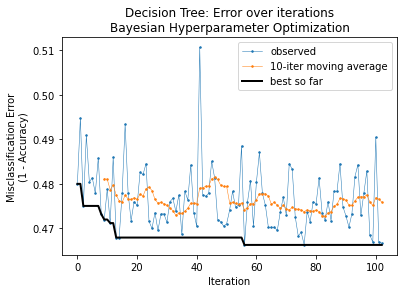

In [11]:
# convergence plot
accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.close('all')
plt.figure()
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Decision Tree: Error over iterations\nBayesian Hyperparameter Optimization")
plt.legend()

Text(0.5, 1.0, 'Decision Tree Runtime\nModel vs. Bayesian Search Contribution')

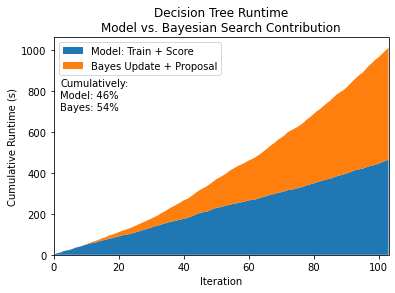

In [12]:
#### runtime plot: model vs. bayesian

plt.close('all')
model_times = np.array(bayes_result.cv_results_['mean_fit_time'])*5 + \
              np.array(bayes_result.cv_results_['mean_score_time'])*5 
total_times = np.array(timercb.iter_time)
bayes_times = total_times - model_times

cumul_totaltime = total_times.cumsum()
cumul_modeltime = model_times.cumsum()
cumul_bayestime = bayes_times.cumsum()

bayes_frac = cumul_bayestime[-1]/cumul_totaltime[-1]
model_frac = cumul_modeltime[-1]/cumul_totaltime[-1]

plt.stackplot(range(0, len(model_times) + 1), [0, *cumul_modeltime], [0, *cumul_bayestime], 
              labels=['Model: Train + Score', 'Bayes Update + Proposal'])
plt.legend(loc='upper left')
plt.xlim((0, len(model_times)))
plt.xlabel('Iteration')
plt.ylabel('Cumulative Runtime (s)')
plt.annotate('Cumulatively:\nModel: {}%\nBayes: {}%'.format(round(model_frac * 100), round(bayes_frac * 100)), 
             (0.02*len(model_times), 0.7*cumul_totaltime[-1]))
plt.title('Decision Tree Runtime\nModel vs. Bayesian Search Contribution')

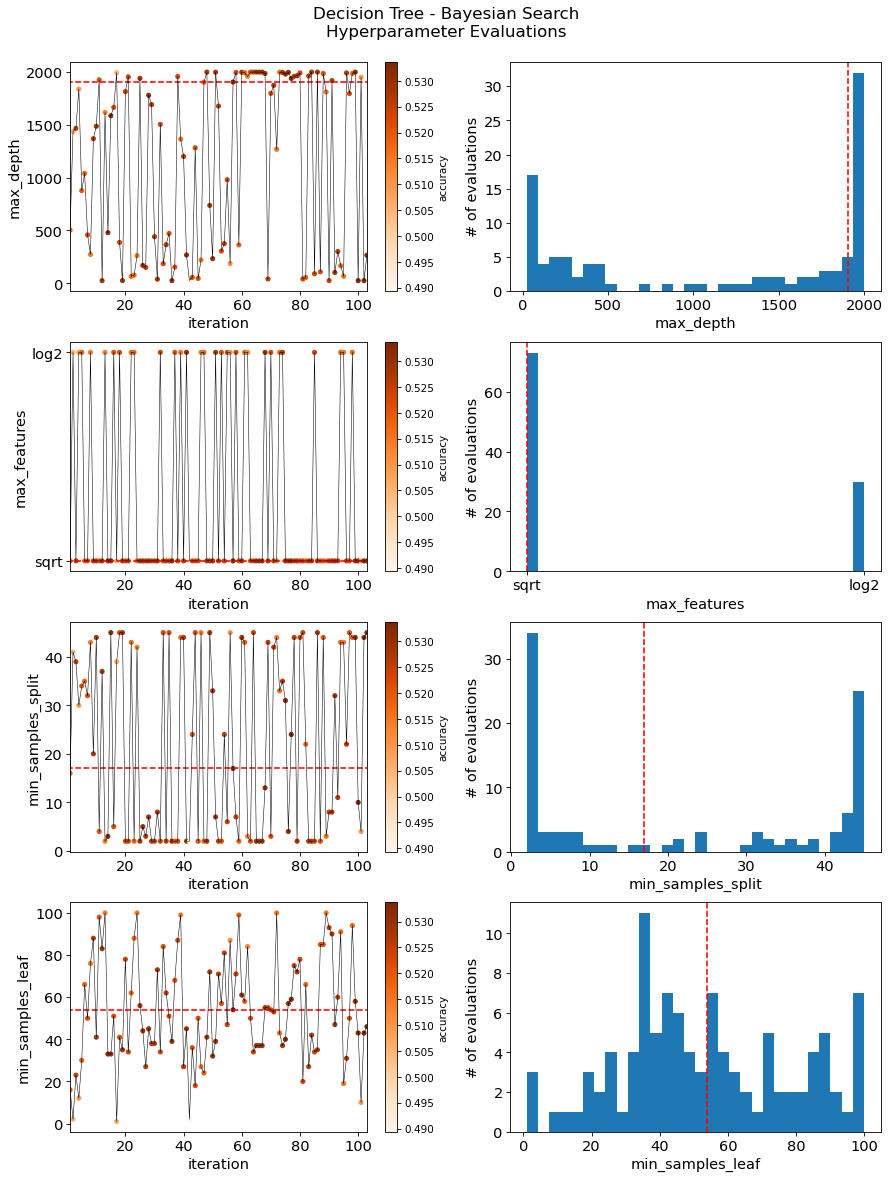

In [13]:
accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs


params = bayes_result.search_spaces.keys()
plt.figure(figsize=(12, 4*len(params)), dpi=75)

for i, param in enumerate(params):
    plt.subplot(len(params), 2, 2*i+1)
    param_vals = bayes_result.cv_results_[f'param_{param}']
    if type(param_vals[0]) == bool:
        param_vals = [str(x) for x in param_vals]
    best_val = bayes_result.best_params_[param]

    plt.scatter(np.arange(1,len(param_vals)+1), param_vals, s=15, c=accs, cmap="Oranges", label="Accuracy")
    plt.plot(np.arange(1,len(param_vals)+1), param_vals, 'k', linewidth=0.5)
    plt.xlim(1, len(param_vals))
    plt.hlines(best_val, 0, len(param_vals), 'r', 'dashed')

    plt.ylabel(param, fontsize=14)
    plt.xlabel("iteration", fontsize=14)
    cb = plt.colorbar()
    cb.set_label("accuracy")
    plt.tick_params(labelsize=14)

    
    plt.subplot(len(params), 2, 2*i+2)
    plt.hist(param_vals, bins=30)
    plt.axvline(x=best_val, color='red', linestyle='--')
    plt.xlabel(param, fontsize=14)
    plt.ylabel('# of evaluations', fontsize=14)
    plt.tick_params(labelsize=14)
    
plt.suptitle("Decision Tree - Bayesian Search\nHyperparameter Evaluations", size=16)
plt.tight_layout(rect=[0, 0.0, 1, 0.98])


# Combined Plots

In [31]:
############################ 
# If re-running this later, or if your connection failed, re-import the results for subsequent plots
############################ 

#with open('decisiontree_gs_results_201206_210847.pkl', 'rb') as f:
#    gs_results = pickle.load(f)
#gs = gs_results['gs']
#gs_results = gs_results['gs_results']

#with open('decisiontree_rs_results_201206_213128.pkl', 'rb') as f:
#    rs_results = pickle.load(f)
#rs = rs_results['rs']
#rs_results = rs_results['rs_results']

#bayes_result = skopt.load('decisiontree_bayes_result_20201213_091811.pkl')

In [32]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

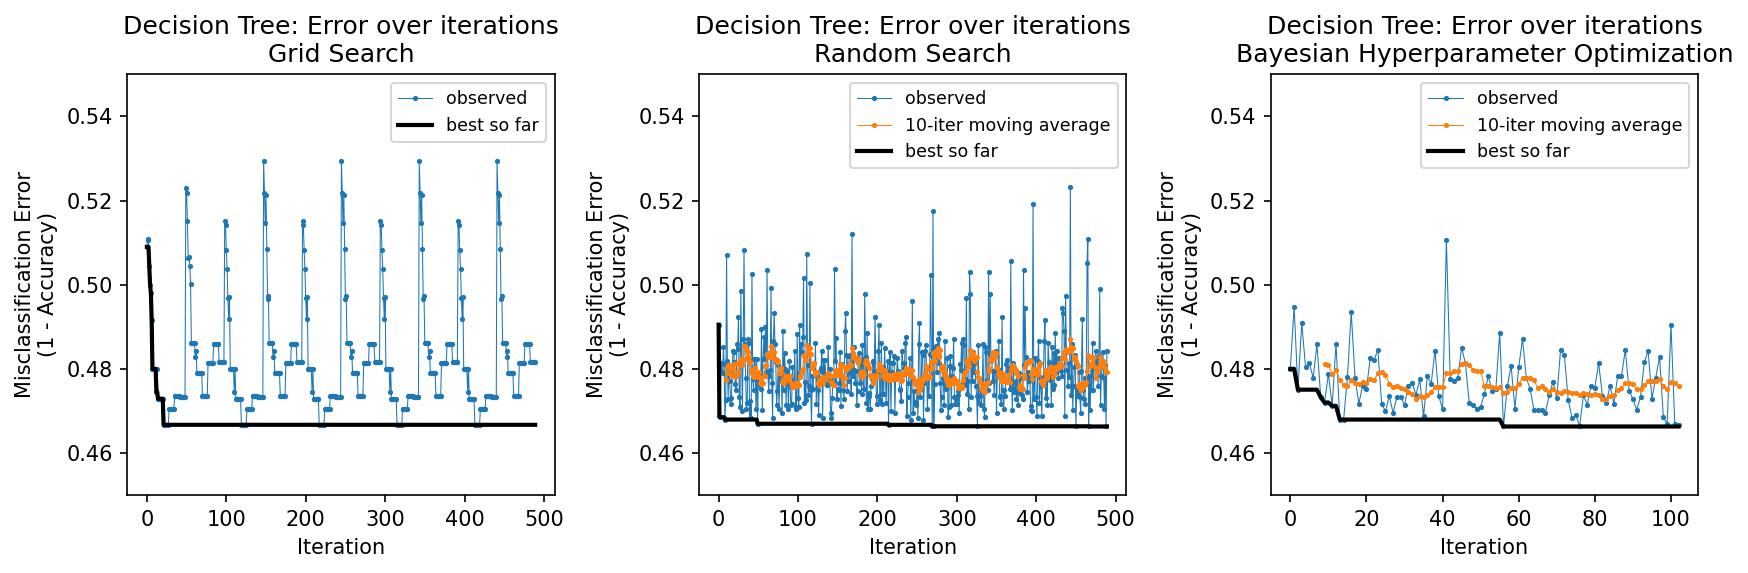

In [35]:
plt.close('all')
plt.figure(figsize=(12, 4), dpi=150)


####### convergence plot, GS
plt.subplot(1, 3, 1)

accs = np.array([x['mean_metric'] for x in gs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs
plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Decision Tree: Error over iterations\nGrid Search")
plt.legend(loc="upper right", fontsize="small")
plt.ylim((.45, .55))


####### convergence plot, RS
plt.subplot(1, 3, 2)

accs = np.array([x['mean_metric'] for x in rs_results])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Decision Tree: Error over iterations\nRandom Search")
plt.legend(loc="upper right", fontsize="small")
plt.ylim((.45, .55))


####### convergence plot, Bayesian
plt.subplot(1, 3, 3)

accs = np.array(bayes_result.cv_results_['mean_test_score'])
cumul_accs = np.maximum.accumulate(accs)
errs = 1-accs
cumul_errs = 1-cumul_accs

WINDOW_SIZE = 10
move_avg_err = 1 - moving_average(accs, WINDOW_SIZE)
move_avg_err = [*([None]*(WINDOW_SIZE - 1)), *list(move_avg_err)]

plt.plot(errs, linewidth=0.5, label="observed", marker='.', markersize=3)
plt.plot(move_avg_err, linewidth=0.5, label="10-iter moving average", marker='.', markersize=3)
plt.plot(cumul_errs, 'k', linewidth=2, label="best so far")
plt.xlabel("Iteration")
plt.ylabel("Misclassification Error\n(1 - Accuracy)")
plt.title("Decision Tree: Error over iterations\nBayesian Hyperparameter Optimization")
plt.legend(loc="upper right", fontsize="small")
plt.ylim((.45, .55))


plt.tight_layout(rect=[0, 0.0, .96, 0.98])

# Get CSVs + best model summaries

In [36]:
print('\nGrid search best model:')
best = max(gs_results, key=lambda item: item['mean_metric'])
print('    Score = {}'.format(best['mean_metric']))

for param in sorted(best['params'].keys()):
    print('    {} = {}'.format(param, best['params'][param]))


Grid search best model:
    Score = 0.5333
    max_depth = 25
    max_features = sqrt
    min_samples_leaf = 46
    min_samples_split = 2


In [37]:
print('\nRandom search best model:')
best = max(rs_results, key=lambda item: item['mean_metric'])
print('    Score = {}'.format(best['mean_metric']))

for param in sorted(best['params'].keys()):
    print('    {} = {}'.format(param, best['params'][param]))


Random search best model:
    Score = 0.5337
    max_depth = 1347
    max_features = sqrt
    min_samples_leaf = 54
    min_samples_split = 8


In [38]:
print('\nBayes search best model:')
print('    Score = {}'.format(bayes_result.best_score_))
for param in sorted(bayes_result.best_params_.keys()):
    print('    {} = {}'.format(param, bayes_result.best_params_[param]))


Bayes search best model:
    Score = 0.5337
    max_depth = 1906
    max_features = sqrt
    min_samples_leaf = 54
    min_samples_split = 17


In [39]:
df_results = pd.DataFrame()
for res in gs_results:
    row = {'search_type': 'grid', 'accuracy': res['mean_metric'], **res['params']}
    df_results = df_results.append(row, ignore_index=True)

In [40]:
for res in rs_results:
    row = {'search_type': 'random', 'accuracy': res['mean_metric'], **res['params']}
    df_results = df_results.append(row, ignore_index=True)

In [41]:
for i, cv_score in enumerate(bayes_result.cv_results_['mean_test_score']):
    row = {'search_type': 'bayes', 'accuracy': cv_score}
    for param in bayes_result.search_spaces.keys():
        row[param] = bayes_result.cv_results_['param_' + param][i]
    df_results = df_results.append(row, ignore_index=True)

In [42]:
df_results.to_csv('decisiontree_results_{}.csv'.format(datetime.now().strftime('%Y%m%d-%H%M%S')), index=False)